In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris 
from scipy.sparse import csr_matrix
from lib.gradient_tools import BasicGradientUpdater
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics.pairwise import linear_kernel
from lib.sparse_tools import sparse_clip, sparse_pos_clip, dense_pos_clip, sparse_sparse_dot, dense_sparse_add, \
                             dense_sparse_mul, sparse_sub_with_clip

In [2]:
iris_data = load_iris()

In [3]:
km = csr_matrix(linear_kernel(iris_data["data"]))
n = km.shape[0]
y = iris_data["target"]
y[y > 0] = 1

-----

## SkLearn

In [4]:
%%time
y = [0] * 50 + [1]*100
clf = SVC(kernel="precomputed", probability=True)
clf.fit(km.toarray(), y)
print(classification_report(y, clf.predict(km.toarray())))
print(roc_auc_score(y, clf.predict_proba(km.toarray())[:, 1]))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00       150

1.0
CPU times: user 3.74 ms, sys: 1.28 ms, total: 5.02 ms
Wall time: 3.92 ms


In [5]:
clf.support_

array([23, 41, 98], dtype=int32)

## Ours

In [6]:
# Input:
# km: csr_matrix
# y: np.array

C = 1.0
γ = 5000. # O(n)
L1 = 2*γ
ε = 1e-3
n_iter = 500


inv2nC = 1. / (2 * n * C)
invL1 = 1. / L1
fracCL1 = C / L1

y = np.array([+1.] * 50 + [-1.] * 100)

# γy = γ * y

In [7]:
def grad_f(x):
    t = x.copy()
    t.data -= 1 / (2 * n * C)
    return (-csr_matrix([1] * n).T + km.multiply(y.reshape(1, -1) * y.reshape(-1, 1)).dot(x.T) + \
           γ*sparse_clip(-x.T, 0, None) + γ*sparse_clip(t.T, 0, None)).T

In [8]:
%%time

# Initialize gradient heap

ν = csr_matrix(([0., 0.], [1, 2], [0, 2]), shape=(1, n))

# grad1 = dense_sparse_add(-y, 2 * (km[0] - km[1]))

# yν_ = dense_sparse_mul(y, ν)
# yν1 = sparse_pos_clip(-yν_)
# yν2 = sparse_sub_with_clip(yν_, inv2nC)
# grad2 = dense_sparse_mul(γy, yν1 + yν2)

# grad = dense_sparse_add(grad1, grad2)
# min_heap = BasicGradientUpdater(grad)
# max_heap = BasicGradientUpdater(-grad)

# Iterate until stopping criteria is met

norms = []
h_vals = []

for t in range(n_iter):
    ν_prev = ν.copy()
    
    current_grad = dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν)))
    norms.append(sparse.linalg.norm(current_grad))
    
    min_ix = current_grad.argmin()
    max_ix = current_grad.argmax()
    min_val = current_grad.min()
    max_val = current_grad.max()
    h_val = fracCL1 * (max_val - min_val)
    h_vec = csr_matrix(([-h_val, +h_val], [min_ix, max_ix], [0, 2]), shape=(1, n))
    h_vec.sort_indices()
    h_vals.append(h_val)

    ν += h_vec
    assert np.abs(ν.sum()) <= 1e-6

    # Gradient update
#     νinvL1h = ν_prev + invL1 * h_vec
#     δ1 = (2 * h_val / L1) * (km[min_ix] - km[max_ix])
#     δ21 =  sparse_pos_clip(dense_sparse_mul(-y, νinvL1h))
#     δ22 = -sparse_pos_clip(dense_sparse_mul(-y, ν_prev))
#     δ23 =  sparse_sub_with_clip(dense_sparse_mul(y, νinvL1h), inv2nC)
#     δ24 = -sparse_sub_with_clip(dense_sparse_mul(y, ν_prev), inv2nC)
#     δ2 = dense_sparse_mul(γy, δ21 + δ22 + δ23 + δ24)
#     δ = δ1 + δ2
#     δ = np.asarray(dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))) - min_heap.get())[0]

λ = dense_sparse_mul(y, ν)

CPU times: user 1.46 s, sys: 9.27 ms, total: 1.47 s
Wall time: 1.48 s


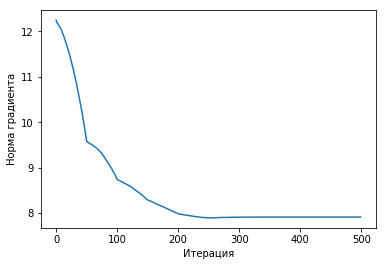

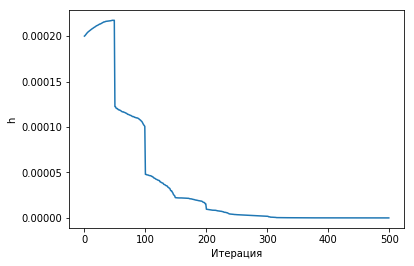

In [9]:
plt.xlabel("Итерация")
plt.ylabel("Норма градиента")
plt.plot(norms)
plt.show()
plt.xlabel("Итерация")
plt.ylabel("h")
plt.plot(h_vals)
plt.show()

In [10]:
dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))).data

array([0.64611892, 0.64612185, 0.64612267, 0.64611831, 0.64611888,
       0.64611884, 0.64612214, 0.64612071, 0.64612414, 0.64612064,
       0.64612032, 0.64611813, 0.64611949, 0.64611951, 0.64612185,
       0.64611977, 0.64611962, 0.64612208, 0.64612076, 0.64612214,
       0.64612219, 0.64612235, 0.64611895, 0.64612324, 0.64611993,
       0.64611907, 0.64612315, 0.64612186, 0.64611915, 0.64612206,
       0.64612469, 0.64612219, 0.646123  , 0.64612205, 0.64611814,
       0.64612319, 0.64612325, 0.64612018, 0.64612087, 0.646122  ,
       0.64612099, 0.64612235, 0.64611984, 0.646122  , 0.64611828,
       0.64612206, 0.64611854, 0.64611935, 0.64611825, 0.64612032,
       0.64612337, 0.64612017, 0.64612556, 0.64611839, 0.64612018,
       0.64611768, 0.64612204, 0.64612405, 0.6461201 , 0.64612073,
       0.64612183, 0.64611894, 0.64612108, 0.6461186 , 0.64611817,
       0.64612006, 0.64611874, 0.64612315, 0.64612469, 0.64612187,
       0.64611757, 0.64612179, 0.64611964, 0.64612174, 0.64612

---